In [1]:
import numpy as np
import torch

from tqdm.auto import tqdm

import itertools

In [2]:
import os
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv(), verbose=True)

True

In [3]:
DEVICE = torch.device('cuda:1')

In [4]:
from pathlib import Path

results_dir = Path(os.getenv('RESULTS_DIR'))
print('results_dir', results_dir)

finished_runs = [path.parent for path in results_dir.glob('**/prediction.npy')]
# print('finished_runs', len(finished_runs))

results_dir /data/huze/ray_results/algonauts2021


In [5]:
from pprint import pprint

exapmle_files = list(path.name for path in finished_runs[0].iterdir())
pprint(exapmle_files)

['events.out.tfevents.1645665929.yfwu-guslab.102516.0',
 'params.json',
 'progress.csv',
 'result.json',
 'hparams.yaml',
 'events.out.tfevents.1645665890.yfwu-guslab',
 'prediction.npy',
 'voxel_embedding.npy',
 'params.pkl']


In [6]:
import yaml
from yaml import CLoader
import json
import pandas as pd
from src.config.config import flatten

finished_runs = [path.parent for path in results_dir.glob('**/prediction.npy')]

run_meta_infos = []
for run_dir in tqdm(finished_runs):
    hparams = yaml.load(run_dir.joinpath('hparams.yaml').open(), Loader=CLoader)
    run_meta_info = flatten(hparams)
    run_meta_info['path'] = run_dir

    data = [json.loads(line) for line in run_dir.joinpath('result.json').open()]
    ddf = pd.DataFrame(data)
    run_meta_info['score'] = ddf.val_corr.max()
    run_meta_info['time'] = ddf.time_total_s.max()

    run_meta_infos.append(run_meta_info)

run_df = pd.DataFrame(run_meta_infos)

print(f'total GPU time {run_df.time.sum() / 3600:.2f}h')

  0%|          | 0/780 [00:00<?, ?it/s]

total GPU time 133.11h


In [7]:
run_df[(run_df['MODEL.BACKBONE.NAME'].isin(['i3d_rgb', 'i3d_flow']))&
       (run_df['MODEL.NECK.SPP_LEVELS'] == (2, )) &
       (run_df['DATASET.ROI'] == 'WB')][
    ['MODEL.BACKBONE.NAME', 'DATASET.ROI', 'MODEL.BACKBONE.LAYERS', 'MODEL.NECK.SPP_LEVELS', 'score']].sort_values('DATASET.ROI')

,MODEL.BACKBONE.NAME,DATASET.ROI,MODEL.BACKBONE.LAYERS,MODEL.NECK.SPP_LEVELS,score
37,i3d_flow,WB,"(x2,)","(2,)",0.117432
63,i3d_flow,WB,"(x4,)","(2,)",0.116271
78,i3d_flow,WB,"(x1,)","(2,)",0.096289
120,i3d_flow,WB,"(x3,)","(2,)",0.125430
340,i3d_rgb,WB,"(x2,)","(2,)",0.115909
556,i3d_rgb,WB,"(x4,)","(2,)",0.142271
641,i3d_rgb,WB,"(x1,)","(2,)",0.098155
697,i3d_rgb,WB,"(x3,)","(2,)",0.128231


# prepare data

In [8]:
from src.utils.ensemble import optimize_val_correlation
from src.config.config import combine_cfgs, get_cfg_defaults
from src.data.datamodule import MyDataModule

In [9]:
# prepare validation data
cfg = combine_cfgs('../src/config/experiments/algonauts2021_i3d_flow.yml')
dm = MyDataModule(cfg)
dm.prepare_data()
dm.setup()

val_indices = dm.val_dataset.indices

cache_path = Path('/home/huze/.cache/val_fmris.pt')

if cache_path.exists():
    val_fmris = torch.load(cache_path)
else:
    val_fmris = [dm.dataset_train_val.__getitem__(i) for i in tqdm(val_indices)]
    val_fmris = np.stack(val_fmris, 0)
    val_fmris = torch.tensor(val_fmris)
    torch.save(val_fmris, cache_path)

In [10]:
def get_ensemble_prediction_from_tensor_list(predicions_list, roi_val_fmris, val_indices, opt_verbose=False):
    predictions = torch.stack(predicions_list, -1)
    ws = optimize_val_correlation(predictions[val_indices],
                                  roi_val_fmris,
                                  verbose=opt_verbose,
                                  device=DEVICE)
    new_predictions = predictions @ ws
    return new_predictions


def get_ensemble_prediction_from_df(roi_df, wb_df, val_indices, roi_val_fmris, roi_voxel_indices, opt_verbose=False):
    roi_predictions = np.stack([
        np.load(path.joinpath('prediction.npy'))
        for path in roi_df['path'].values
    ], -1)
    wb_predictions = np.stack([
        np.load(path.joinpath('prediction.npy'))[..., roi_voxel_indices]
        for path in wb_df['path'].values
    ], -1)
    predictions = np.concatenate([roi_predictions, wb_predictions], -1)

    predictions = torch.tensor(predictions).float()
    ws = optimize_val_correlation(predictions[val_indices],
                                  roi_val_fmris,
                                  verbose=opt_verbose,
                                  device=DEVICE)
    new_predictions = predictions @ ws
    return new_predictions

# 3 level of hierarchical ensemble

In [11]:
from src.utils.rigistry import Registry
from src.utils.misc import my_query_df

ORDERED_HIERACHY_KEYS = ['MODEL.BACKBONE.NAME', 'MODEL.BACKBONE.LAYERS', 'MODEL.NECK.SPP_LEVELS']

HEFN_REGISTRY = Registry()


@HEFN_REGISTRY.register('H1')
def H1_ens_roi(run_df, roi, verbose=True, opt_verbose=False, he_keys=ORDERED_HIERACHY_KEYS):
    configs = list(itertools.product(*[run_df[k].unique() for k in he_keys[0:]]))

    roi_voxel_indices = torch.load(os.path.join(cfg.DATASET.VOXEL_INDEX_DIR, f'{roi}.pt'))
    roi_val_fmris = val_fmris[..., roi_voxel_indices]

    predictions_list = []
    for vs in configs:
        vs = (*vs,)
        _l1_df = my_query_df(run_df, equal_dict={k: v for k, v in zip(he_keys, vs)})
        roi_l1_df = _l1_df.loc[_l1_df['DATASET.ROI'] == roi]
        wb_l1_df = _l1_df.loc[_l1_df['DATASET.ROI'] == 'WB']
        if not (len(roi_l1_df) == 1 and len(wb_l1_df) == 1):
            print('skipped...\t', roi, vs, '\t',
                  f'roi={len(roi_l1_df)}', f'wb={len(wb_l1_df)}', '\t warning: no paried run')
            continue
        if verbose:
            print('Level 0...\t', roi, vs, '\t')
        new_predictions = get_ensemble_prediction_from_df(roi_l1_df, wb_l1_df, val_indices,
                                                          roi_val_fmris, roi_voxel_indices, opt_verbose=opt_verbose)
        predictions_list.append(new_predictions)

    if verbose:
        print('Level 1...\t', roi, '\t')
    new_predictions = get_ensemble_prediction_from_tensor_list(predictions_list, roi_val_fmris, val_indices,
                                                               opt_verbose=opt_verbose)
    return new_predictions


@HEFN_REGISTRY.register('H2')
def H2_ens_roi(run_df, roi, verbose=True, opt_verbose=False, he_keys=ORDERED_HIERACHY_KEYS):
    configs = list(itertools.product(*[run_df[k].unique() for k in he_keys[1:]]))

    roi_voxel_indices = torch.load(os.path.join(cfg.DATASET.VOXEL_INDEX_DIR, f'{roi}.pt'))
    roi_val_fmris = val_fmris[..., roi_voxel_indices]

    o_predictions_list = []
    for v1 in run_df[he_keys[0]].unique():
        predictions_list = []
        for vs in configs:
            vs = (v1, *vs)
            _l1_df = my_query_df(run_df, equal_dict={k: v for k, v in zip(he_keys, vs)})
            roi_l1_df = _l1_df.loc[_l1_df['DATASET.ROI'] == roi]
            wb_l1_df = _l1_df.loc[_l1_df['DATASET.ROI'] == 'WB']
            if not (len(roi_l1_df) == 1 and len(wb_l1_df) == 1):
                print('skipped...\t', roi, vs, '\t',
                      f'roi={len(roi_l1_df)}', f'wb={len(wb_l1_df)}', '\t warning: no paried run')
                continue
            if verbose:
                print('Level 0...\t', roi, vs, '\t')
            new_predictions = get_ensemble_prediction_from_df(roi_l1_df, wb_l1_df, val_indices,
                                                              roi_val_fmris, roi_voxel_indices, opt_verbose=opt_verbose)
            predictions_list.append(new_predictions)

        if verbose:
            print('Level 1...\t', roi, v1, '\t')
        new_predictions = get_ensemble_prediction_from_tensor_list(predictions_list, roi_val_fmris, val_indices,
                                                                   opt_verbose=opt_verbose)
        o_predictions_list.append(new_predictions)
    if verbose:
        print('Level 2...\t', roi, '\t')
    new_predictions = get_ensemble_prediction_from_tensor_list(o_predictions_list, roi_val_fmris, val_indices,
                                                               opt_verbose=opt_verbose)
    return new_predictions


@HEFN_REGISTRY.register('H3')
def H3_ens_roi(run_df, roi, verbose=True, opt_verbose=False, he_keys=ORDERED_HIERACHY_KEYS):
    configs = list(itertools.product(*[run_df[k].unique() for k in he_keys[2:]]))

    roi_voxel_indices = torch.load(os.path.join(cfg.DATASET.VOXEL_INDEX_DIR, f'{roi}.pt'))
    roi_val_fmris = val_fmris[..., roi_voxel_indices]

    oo_predictions_list = []
    for v11 in run_df[he_keys[0]].unique():
        o_predictions_list = []
        for v1 in run_df[he_keys[1]].unique():
            predictions_list = []
            for vs in configs:
                vs = (v11, v1, *vs)
                _l1_df = my_query_df(run_df, equal_dict={k: v for k, v in zip(he_keys, vs)})
                roi_l1_df = _l1_df.loc[_l1_df['DATASET.ROI'] == roi]
                wb_l1_df = _l1_df.loc[_l1_df['DATASET.ROI'] == 'WB']
                if not (len(roi_l1_df) == 1 and len(wb_l1_df) == 1):
                    print('skipped...\t', roi, vs, '\t',
                          f'roi={len(roi_l1_df)}', f'wb={len(wb_l1_df)}', '\t warning: no paried run')
                    continue
                if verbose:
                    print('Level 0...\t', roi, vs, '\t')
                new_predictions = get_ensemble_prediction_from_df(roi_l1_df, wb_l1_df, val_indices,
                                                                  roi_val_fmris, roi_voxel_indices,
                                                                  opt_verbose=opt_verbose)
                predictions_list.append(new_predictions)

            if verbose:
                print('Level 1...\t', roi, v11, v1, '\t')
            new_predictions = get_ensemble_prediction_from_tensor_list(predictions_list, roi_val_fmris, val_indices,
                                                                       opt_verbose=opt_verbose)
            o_predictions_list.append(new_predictions)
        if verbose:
            print('Level 2...\t', roi, v11, '\t')
        new_predictions = get_ensemble_prediction_from_tensor_list(o_predictions_list, roi_val_fmris, val_indices,
                                                                   opt_verbose=opt_verbose)
        oo_predictions_list.append(new_predictions)
    if verbose:
        print('Level 3...\t', roi, '\t')
    new_predictions = get_ensemble_prediction_from_tensor_list(oo_predictions_list, roi_val_fmris, val_indices,
                                                               opt_verbose=opt_verbose)
    return new_predictions

In [12]:
def roi_hierachical_ensemble(run_df, he_sch: str, verbose=True, opt_verbose=False):
    rois = tuple(r for r in run_df['DATASET.ROI'].unique() if r != 'WB')
    he_fn = HEFN_REGISTRY[he_sch]

    roi_prediction_dict = {}
    for roi in rois:
        roi_prediction = he_fn(run_df, roi, verbose=verbose, opt_verbose=opt_verbose)
        roi_prediction_dict[roi] = roi_prediction

    roi_prediction_dict = {roi: HEFN_REGISTRY[he_sch](run_df, roi, verbose=verbose, opt_verbose=opt_verbose)
                           for roi in tuple(r for r in run_df['DATASET.ROI'].unique() if r != 'WB')}

    return roi_prediction_dict

In [13]:
def assemble_rois_to_full_brain(roi_sch_dict, roi_prediction_dict, shape):
    # combine rois to full brain
    sch_prediction_dict = {}
    for sch_name, sch_rois in roi_sch_dict.items():
        prediction = torch.zeros(shape)
        for roi in sch_rois:
            voxel_indices = torch.load(os.path.join(cfg.DATASET.VOXEL_INDEX_DIR, f'{roi}.pt'))
            prediction[..., voxel_indices] = roi_prediction_dict[roi]
        sch_prediction_dict[sch_name] = prediction
    return sch_prediction_dict

# define ensemble sche gird space

In [14]:
from itertools import chain, combinations


def powerset(iterable):
    """
    powerset([1,2,3]) --> (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)
    """
    xs = list(iterable)
    # note we return an iterator rather than a list
    return chain.from_iterable(combinations(xs, n) for n in range(1, len(xs) + 1))

In [15]:
# MODEL.BACKBONE.LAYERS
_model_sch_dfs = {
    "single_layer+multi_layer": run_df,
    "single_layer": run_df[run_df.apply(lambda row: len(row['MODEL.BACKBONE.LAYERS']) == 1, axis=1)],
    "multi_layer": run_df[run_df.apply(lambda row: len(row['MODEL.BACKBONE.LAYERS']) > 1, axis=1)],
}

# MODEL.BACKBONE.NAME
model_sch_dfs = {}

backbones = run_df['MODEL.BACKBONE.NAME'].unique()
for key, df in _model_sch_dfs.items():
    for backbone_subset in powerset(backbones):
        i_df = pd.concat([df.loc[df['MODEL.BACKBONE.NAME'] == backbone] for backbone in backbone_subset])
        backbone_subset_name = '+'.join(backbone_subset)

        model_sch_dfs[f'{key}&{backbone_subset_name}'] = i_df

In [16]:
# this dict defines how to combine rois to full brain
roi_sch_dict = {
    'ROI': ['V1', 'V2', 'V3', 'V4', 'EBA', 'LOC', 'PPA', 'FFA', 'STS', 'REST'],
    'LC': ['LC1', 'LC2', 'LC3', 'LC4', 'LC5'],
    'MC': ['MC1', 'MC2', 'LC2', 'LC3', 'LC4', 'LC5'],
    'SMC': ['SMC1', 'SMC2', 'MC2', 'LC2', 'LC3', 'LC4', 'LC5'],
    'SC': ['SMC1', 'SMC2', 'SC3', 'SC4', 'LC2', 'LC3', 'LC4', 'LC5'],
}

# heavy lift from there

In [17]:
tmp_dir = '/data/huze/tmp/mkii/'
tmp_dir = Path(tmp_dir)
tmp_dir.mkdir(parents=False, exist_ok=True)

In [18]:
def iprint(list):
    for (num, item) in enumerate(list):
        print(num + 1, item)
    print()


model_schs = np.asarray(list(model_sch_dfs.keys()))
print("model_schs")
iprint(model_schs)
he_schs = np.asarray(list(HEFN_REGISTRY.keys()))
print("he_schs")
iprint(he_schs)
rois = [r for r in run_df['DATASET.ROI'].unique() if r != 'WB']
print("rois")
iprint(rois)

model_schs
1 single_layer+multi_layer&i3d_flow
2 single_layer+multi_layer&i3d_rgb
3 single_layer+multi_layer&i3d_flow+i3d_rgb
4 single_layer&i3d_flow
5 single_layer&i3d_rgb
6 single_layer&i3d_flow+i3d_rgb
7 multi_layer&i3d_flow
8 multi_layer&i3d_rgb
9 multi_layer&i3d_flow+i3d_rgb

he_schs
1 H1
2 H2
3 H3

rois
1 LC5
2 PPA
3 REST
4 V1
5 V2
6 LC2
7 MC1
8 LC4
9 V3
10 SMC1
11 V4
12 LOC
13 FFA
14 LC3
15 LC1
16 MC2
17 SMC2
18 EBA
19 SC3
20 STS
21 SC4



In [19]:
# model_schs = model_schs[:1]
model_schs = model_schs[np.asarray([4])]
he_schs = he_schs[np.asarray([2])]

In [20]:
print(model_schs, he_schs)

['single_layer&i3d_rgb'] ['H3']


In [ ]:
# heavy lift

verbose = True
opt_verbose = False

for model_sch in model_schs:
    df = model_sch_dfs[model_sch]

    print(model_sch, 'runs:', len(df))
    if len(df) == 0:
        continue

    for he_sch in he_schs[:]:

        print('working on...', model_sch, he_sch)

        # ROI hierarchical ensemble
        roi_prediction_dict = {roi: HEFN_REGISTRY[he_sch](df, roi, verbose=verbose, opt_verbose=opt_verbose)
                               for roi in tqdm(rois, desc=f'he_sch={he_sch} \t model_sch={model_sch}')}
        # "assemble" ROIs to full brain
        wb_shape = np.load(run_df.loc[run_df['DATASET.ROI'] == 'WB'].path.values[0].joinpath('prediction.npy')).shape
        sch_prediction_dict = assemble_rois_to_full_brain(roi_sch_dict, roi_prediction_dict, wb_shape)
        for roi_sch, prediction in sch_prediction_dict.items():
            path = os.path.join(tmp_dir, f'he_sch={he_sch},model_sch={model_sch},roi_sch={roi_sch}'
                                         f'-prediction.pt')
            torch.save(prediction, path)

single_layer&i3d_rgb runs: 616
working on... single_layer&i3d_rgb H3


he_sch=H3 	 model_sch=single_layer&i3d_rgb:   0%|          | 0/21 [00:00<?, ?it/s]

Level 0...	 LC5 ('i3d_rgb', ('x2',), (4,)) 	
Level 0...	 LC5 ('i3d_rgb', ('x2',), (7,)) 	
Level 0...	 LC5 ('i3d_rgb', ('x2',), (1,)) 	
Level 0...	 LC5 ('i3d_rgb', ('x2',), (3,)) 	
Level 0...	 LC5 ('i3d_rgb', ('x2',), (2,)) 	
Level 0...	 LC5 ('i3d_rgb', ('x2',), (6,)) 	
Level 0...	 LC5 ('i3d_rgb', ('x2',), (5,)) 	
Level 1...	 LC5 i3d_rgb ('x2',) 	
Level 0...	 LC5 ('i3d_rgb', ('x1',), (4,)) 	
Level 0...	 LC5 ('i3d_rgb', ('x1',), (7,)) 	
Level 0...	 LC5 ('i3d_rgb', ('x1',), (1,)) 	
Level 0...	 LC5 ('i3d_rgb', ('x1',), (3,)) 	
Level 0...	 LC5 ('i3d_rgb', ('x1',), (2,)) 	
Level 0...	 LC5 ('i3d_rgb', ('x1',), (6,)) 	
Level 0...	 LC5 ('i3d_rgb', ('x1',), (5,)) 	
Level 1...	 LC5 i3d_rgb ('x1',) 	
Level 0...	 LC5 ('i3d_rgb', ('x3',), (4,)) 	
Level 0...	 LC5 ('i3d_rgb', ('x3',), (7,)) 	
Level 0...	 LC5 ('i3d_rgb', ('x3',), (1,)) 	
Level 0...	 LC5 ('i3d_rgb', ('x3',), (3,)) 	
Level 0...	 LC5 ('i3d_rgb', ('x3',), (2,)) 	
Level 0...	 LC5 ('i3d_rgb', ('x3',), (6,)) 	
Level 0...	 LC5 ('i3d_rgb', ('x3

#TODO: first check inner hierarchy is better than none -- yes

# score for ROI-kROI cross product configuration

In [36]:
from src.utils.metrics import vectorized_correlation

In [63]:
roi_schs = list(roi_sch_dict.keys())

In [94]:
rois = run_df['DATASET.ROI'].unique()
rois = ['WB', 'REST', 'V1', 'V2', 'V3', 'V4', 'LOC', 'EBA', 'FFA', 'STS', 'PPA', 'SMC1', 'SMC2', 'MC2', 'MC1', 'SC3', 'SC4', 'LC1',
        'LC2', 'LC3', 'LC4', 'LC5']

In [95]:
len(rois)

22

In [96]:
score_res_dicts = []

verbose = False

for model_sch, he_sch, trained_roi_sch in tqdm(list(itertools.product(model_schs, he_schs, roi_schs))):
    path = os.path.join(tmp_dir, f'he_sch={he_sch},model_sch={model_sch},roi_sch={trained_roi_sch}'
                                 f'-prediction.pt')
    prediction = torch.load(path)
    scores = vectorized_correlation(prediction[val_indices], val_fmris)
    for roi in rois:
        voxel_indices = torch.load(os.path.join(cfg.DATASET.VOXEL_INDEX_DIR, f'{roi}.pt'))
        score = scores[voxel_indices].mean().item()
        res_dict = {
            'model_sch': model_sch,
            'he_sch': he_sch,
            'trained_roi_sch': trained_roi_sch,
            'roi': roi,
            'score': score,
        }
        score_res_dicts.append(res_dict)
        if verbose:
            print(res_dict)
score_df = pd.DataFrame(score_res_dicts)

  0%|          | 0/15 [00:00<?, ?it/s]

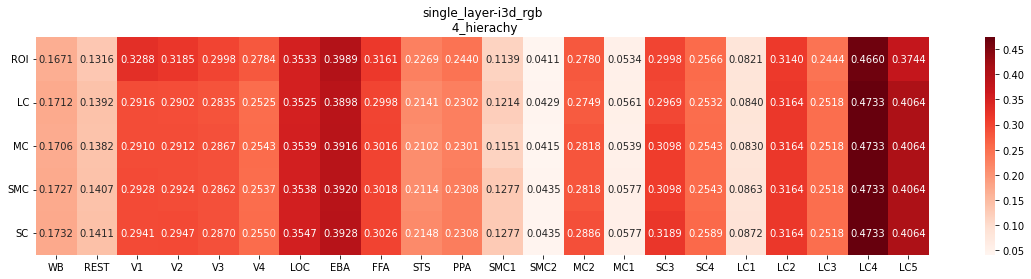

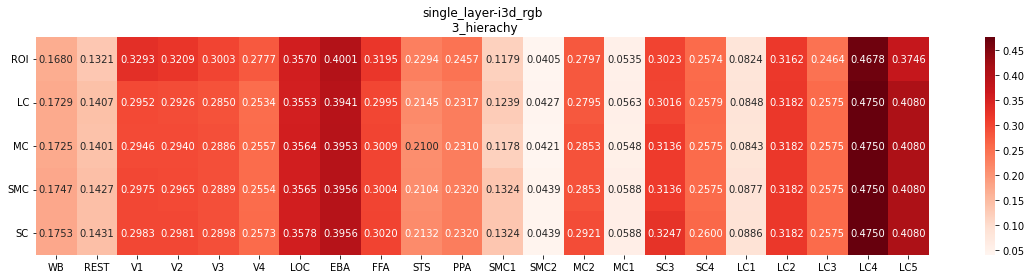

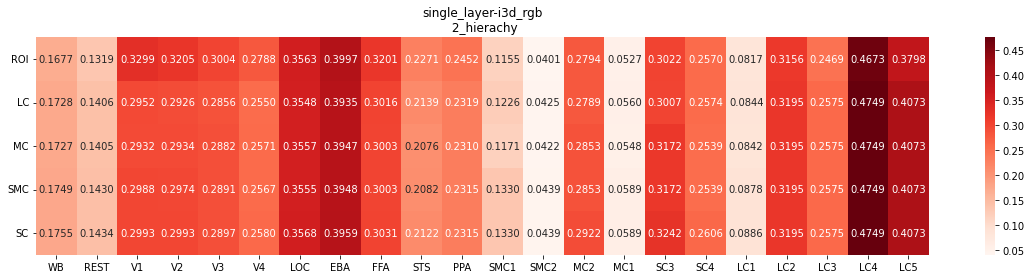

In [117]:
import seaborn as sns
import matplotlib.pyplot as plt

for model_sch, he_sch in list(itertools.product(model_schs, he_schs)):
    idf = my_query_df(score_df, {'model_sch': model_sch, 'he_sch': he_sch})
    x = idf.trained_roi_sch.unique()
    y = idf.roi.unique()
    shape = (len(x), len(y))
    scores = idf.score.values.reshape(shape)
    ax, fig = plt.subplots(figsize=(20, 4))
    sns.heatmap(scores, xticklabels=y, yticklabels=x, annot=True, fmt='.4f', cmap='Reds')
    plt.yticks(rotation=0)
    plt.title(f'{model_sch}\n {he_sch}')
    plt.show()

# cross ROI-kROI model, swap or ensemble?

In [ ]:
from src.utils.metrics import vectorized_correlation

In [19]:
sch_rois2_names = list(roi_sch_dict.keys())
sch_rois2_names.remove('ROI')

In [21]:
cross_roi_res_dicts = []
for model_sch in model_schs:
    for he_sch in he_schs:
        sch_rois1_name = 'ROI'
        sch_rois1 = roi_sch_dict[sch_rois1_name]
        for sch_rois2_name in sch_rois2_names:
            sch_rois2 = roi_sch_dict[sch_rois2_name]
            path1 = os.path.join(tmp_dir,
                                 f'he_sch={he_sch},model_sch={model_sch},roi_sch={sch_rois1_name}'
                                 f'-prediction.pt')
            prediction1 = torch.load(path1)
            path2 = os.path.join(tmp_dir,
                                 f'he_sch={he_sch},model_sch={model_sch},roi_sch={sch_rois2_name}'
                                 f'-prediction.pt')
            prediction2 = torch.load(path2)

            new_prediction_swap = torch.zeros(prediction1.shape)
            new_prediction_ensemble = torch.zeros(prediction1.shape)

            for roi1_name, roi2_name in itertools.product(sch_rois1, sch_rois2):
                voxel_indices1 = torch.load(os.path.join(cfg.DATASET.VOXEL_INDEX_DIR, f'{roi1_name}.pt'))
                voxel_indices2 = torch.load(os.path.join(cfg.DATASET.VOXEL_INDEX_DIR, f'{roi2_name}.pt'))
                intersect_vi = torch.tensor(np.intersect1d(voxel_indices1, voxel_indices2))

                if len(intersect_vi) > 0:
                    scores = np.asarray([
                        vectorized_correlation(prediction1[val_indices][..., intersect_vi],
                                               val_fmris[..., intersect_vi]).mean().item(),
                        vectorized_correlation(prediction2[val_indices][..., intersect_vi],
                                               val_fmris[..., intersect_vi]).mean().item(),
                    ])

                    predictions = torch.stack([prediction1[..., intersect_vi],
                                               prediction2[..., intersect_vi]], -1)

                    # swap to better score model
                    swap_prediction = predictions[..., scores.argmax()]
                    swap_score = np.max(scores)
                    new_prediction_swap[..., intersect_vi] = swap_prediction

                    # ensemble (subject to overfit)
                    ws = optimize_val_correlation(predictions[val_indices], val_fmris[..., intersect_vi], device=DEVICE)
                    ensemble_prediction = predictions @ ws
                    ensemble_score = vectorized_correlation(ensemble_prediction[val_indices],
                                                            val_fmris[..., intersect_vi]).mean().item()
                    new_prediction_ensemble[..., intersect_vi] = ensemble_prediction

                else:
                    # no voxel
                    scores = [0, 0]
                    swap_score = 0
                    ensemble_score = 0

                cross_roi_res_dicts.append({
                    'model_sch': model_sch,
                    'he_sch': he_sch,
                    'sch_rois1_name': sch_rois1_name,
                    'sch_rois2_name': sch_rois2_name,
                    'roi1_name': roi1_name,
                    'roi2_name': roi2_name,
                    'num_intersect_voxels': len(intersect_vi),
                    'scores': tuple(scores),
                    'swap_score': swap_score,
                    'ensemble_score': ensemble_score,
                })

            path1_new = os.path.join(tmp_dir,
                                     f'he_sch={he_sch},model_sch={model_sch},roi_sch={sch_rois1_name}x{sch_rois2_name},'
                                     f'cross_roi_sch=swap-prediction.pt')
            torch.save(new_prediction_swap, path1_new)
            path2_new = os.path.join(tmp_dir,
                                     f'he_sch={he_sch},model_sch={model_sch},roi_sch={sch_rois1_name}x{sch_rois2_name},cross_roi_sch=ensemble-prediction.pt')
            torch.save(new_prediction_ensemble, path2_new)

cross_roi_df = pd.DataFrame(cross_roi_res_dicts)

FileNotFoundError: [Errno 2] No such file or directory: '/data/huze/tmp/he_sch=4_hierachy,model_sch=single_layer-i3d_rgb,roi_sch=ROI-prediction.pt'

# draft

In [ ]:
roi1_names = cross_roi_df.roi1_name.unique()
roi2_names = cross_roi_df.roi2_name.unique()

In [ ]:
num_voxel_data = cross_roi_df.num_intersect_voxels.values.reshape(len(roi1_names), len(roi2_names))
score_data = cross_roi_df.score.values.reshape(len(roi1_names), len(roi2_names))

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('default')

In [ ]:
tab = num_voxel_data
tab = tab / tab.sum(1, keepdims=True)
sns.heatmap(tab, annot=True, fmt='.2f', yticklabels=roi1_names, xticklabels=roi2_names, cmap='Reds')
plt.show()

tab = num_voxel_data
sns.heatmap(tab, annot=True, fmt='d', yticklabels=roi1_names, xticklabels=roi2_names, cmap='Reds')
plt.show()

In [ ]:
tab = score_data
sns.heatmap(tab, annot=True, fmt='.2f', yticklabels=roi1_names, xticklabels=roi2_names, cmap='Reds')
plt.show()